# Modeling2-1_Logistic-Regression
#### Plan
* 기상청 날씨와 주어진 공장내부정보로  결로 예측
    * 우선은 모델링을 위해 24시간 후 아닌, 주어진 시점에서의 날씨와 공장정보로 결로예측해보기.
* 결측값 처리
    * 선형보간법으로 기상청 날씨 결측값 채우기
* 로지스틱으로 예측한 결과 f1-score로 평가

### 분류 모델에 대한 모델 평가
https://bcho.tistory.com/1206
* Accuracy : 재대로 분류된 데이터의 비율
    * (TP+TN) / (전체 데이터 수=P+N)
* Error Rate : 전체 데이터 중에서 잘못 분류한 비율
    * (FN+FP) / (전체 데이터 수=P+N)
* Sensitivity 민감도(Recall or True positive Rate) : 원래 Positive 데이터 수에서 Positive로 분류된 수
    * ex) 결로 발생한게 20개인데, 모델에 있어서 15개가 분류되었으면 Sensitive Rate=0.75 가 된다.
    * SN = (TP) / P
* Precision(정밀성) :Positive로 예측한 내용 중에 실제 Positive 의 비율
    * ex) 결로라고 예측한것이 14개인데, 그중 실제 결로일어난게 14개이면 100%
    * PREC = TP / (TP+FP)
* Specify (True negative Rate)
    * ex) 정상이라고 예측한것 중에, 실제 정상값의 비율
    * SP = TN / (TN+FP)
* False Positive Rate
    * ex) 결로인데, 정상이라고 판단한 비율
        * 이번 프로젝트의 경우 이경우는 크리티컬 하므로, FPR값을 레퍼런스로 사용.
        

### Confusion Matrix를 통해서 계산된 결과를 가지고 모델 평가하는 방법
1. Accuracy
    * 데이터가 balance할때 효과적
    * 데이터가 imbalance하여 각 클래스별 input량이 다를때는 정확하지 않을수도 있다.
2. ROC (Receiver Operating Characteristics) 
    * 가로축 = FP Rate (Specificity) 값의 비율
    * 세로축 = TP Rate (Sensitive) 로 하여 시각화 한 그래프 <br>
<br>
    * 좋은모델인지 판단 기준
        * 그래프가 위로 갈 수록 좋은 모델이고, 적어도 Y=X 그래프보다 위에 있어야 어느정도 쓸모 있는 모델로 볼 수 있다. <br>

  2-1. AUC <br>
    * ROC는 그래프이기 때문에, 모델을 정확도를 하나의 숫자로 나타내기 어려워서 AUC (Area Under Curve) 라는 값을 사용하는데, ROC AUC값은 ROC 그래프의 면적이 된다. 최대값은 1이 된다.  <br>
<br>

3. Precision Recall Plot 
    * 가로축 = Recall
    * 세로축 = Precision
        * 그래프가 위쪽으로 갈수록 정확도가 높은 모델이고, ROC와 마찬가지로 PR 그래프의 AUC (면적)값을 이용하여 모델의 정확도를 평가할 수 있다. 
        
     * Precision Recall Plot (이하 PR 그래프)의 경우도 ROC 와 유사한데, 주로 데이타 라벨의 분포가 심하게 불균등 할때 사용한다.
     
            * 예를 들어 이상 거래 검출 시나리오의 경우 정상 거래의 비율이 비정상 거래에 비해서 압도적으로 많기 때문에 (98%, 2%) 이런 경우에는 ROC 그래프보다 PR 그래프가 분석에 더 유리하다.
            
   * 좋은모델인지 판단 기준
       * ROC 그래프의 경우에는 Y=X 그래프를 기준으로 그래프 윗쪽에 있는 경우 쓸만한 모델로 판단을 했는데, <br>
       PR 그래프의 경우 Base line이라는 것을 사용한다. 
           * Base line = P / (P+N) 으로 정하는데, P는 데이타에서 Positive 레이블의 수, N 은 전체 데이타의 수이다.
           * ex) 결로 데이터가 17개 이고,  전체 데이타가 3108이면 Base line은 17/(3108+17) = 0.005 가 된다. 

4. F1-score
    * Recall과 precision을 이용하여 조화평균을 이용한 score
    * F1 Score = 2 x (Precision x Recall) / (Precision + Recall)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from itertools import cycle
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [3]:
# 한글깨짐 문제
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [180]:
plant1_train=pd.read_csv('./data/plant1_train.csv',index_col=[0],parse_dates=['plant1_train.mea_ddhr'])
plant2_train=pd.read_csv('./data/plant2_train.csv',index_col=[0],parse_dates=['plant2_train.mea_ddhr'])
plant_test=pd.read_csv('./data/plant_test.csv',index_col=[0],parse_dates=['plant_test.mea_ddhr'])

# 서산
seosan=pd.read_csv('./data/asos_서산_시간별.csv',index_col=None,parse_dates=['일시'])
seosan=seosan.rename(columns={'일시':'datetime','기온(°C)':'tem','습도(%)':'hum','이슬점온도(°C)':'dew','증기압(hPa)':'vapor'})
seosan=seosan[['datetime','tem','hum','vapor','dew']]

# test데이터셋과 동일하게 train 데이터 전처리
plant_train=pd.read_csv('./data/plant_train.csv',index_col=[0],parse_dates=['datetime'])

In [181]:
# 공장 컬럼명 정리
plant = [plant1_train, plant2_train, plant_test]

for p in plant:
    p.columns = [col.split('.')[1] for col in p.columns]    
    p.rename(columns={'mea_ddhr':'datetime'}, inplace=True)    

#### 공장별 loc별 데이터 가져오기

In [6]:
# 컬럼에 loc1이 있는 값과 datetime만 가져오기.
### plant1_train데이터 사용시.
loc_col=[]
for c in plant1_train.columns:
    if 'loc1' in c or 'datetime' in c:
        loc_col.append(c)
print(loc_col)

['datetime', 'tem_in_loc1', 'hum_in_loc1', 'tem_coil_loc1', 'tem_out_loc1', 'hum_out_loc1', 'cond_loc1']


#### train데이터 test형식과 같게 만들기
1. plant1,2 각각 불러와서 plant라는 변수를 생성하고, 1, 2 값 넣은 후, rbind(행으로 합치기)
2. tem_in_loc, hum_in_loc, tem_coil_loc, cond_loc 와 같이 location별로 있는 애들에 대해서 melt하고, 변수구분자 드가는 곳에는 loc / 값 들어가는 부분에는 tem_in_loc, hum_in_loc, tem_coil_loc, cond_loc 값으로.
3. 2.에서 각각 바꿔가면서 merge
4. tem_out_loc1, hum_out_loc1 결합.

In [176]:
# plant컬럼을 추가해서 각 데이터프레임에 1, 2 로 채움
plant1_train['plant']=1
plant2_train['plant']=2

# plant 1,2 합치기
plant_train=pd.concat([plant1_train,plant2_train])

In [177]:
tem_in=pd.melt(plant_train[['datetime','tem_in_loc1','tem_in_loc2','tem_in_loc3','plant']],id_vars=['datetime','plant'],var_name='loc',value_name='tem_in')
tem_in['loc']=tem_in['loc'].str.slice(-1)

hum_in=pd.melt(plant_train[['datetime','hum_in_loc1','hum_in_loc2','hum_in_loc3','plant']],id_vars=['datetime','plant'],var_name='loc',value_name='hum_in')
hum_in['loc']=hum_in['loc'].str.slice(-1)

tem_coil=pd.melt(plant_train[['datetime','tem_coil_loc1','tem_coil_loc2','tem_coil_loc3','plant']],id_vars=['datetime','plant'],var_name='loc',value_name='tem_coil')
tem_coil['loc']=tem_coil['loc'].str.slice(-1)

cond=pd.melt(plant_train[['datetime','cond_loc1','cond_loc2','cond_loc3','plant']],id_vars=['datetime','plant'],var_name='loc',value_name='cond')
cond['loc']=cond['loc'].str.slice(-1)

tem_hum_out=plant_train[['datetime','plant','tem_out_loc1','hum_out_loc1']]

In [178]:
plant_train=pd.merge(pd.merge(pd.merge(pd.merge(
    tem_in, hum_in,on=['datetime','plant','loc']),
                                       tem_coil, on=['datetime','plant','loc']),tem_hum_out, on=['datetime','plant']),cond, on=['datetime','plant','loc'])

In [179]:
plant_train.head()

,datetime,plant,loc,tem_in,hum_in,tem_coil,tem_out_loc1,hum_out_loc1,cond
0,2016-04-01 00:00:00,1,1,16.0,24.0,11.0,9.0,42.0,0.0
1,2016-04-01 00:00:00,1,2,14.0,23.0,11.0,9.0,42.0,0.0
2,2016-04-01 00:00:00,1,3,13.0,32.0,10.0,9.0,42.0,0.0
3,2016-04-01 03:00:00,1,1,14.0,28.0,10.0,7.0,59.0,0.0
4,2016-04-01 03:00:00,1,2,12.0,32.0,9.0,7.0,59.0,0.0


#### plant_train 데이터의 datetime기준으로 기상청날씨 left join
* cond가 nan인 row는 모두 제거
* 나머지 결측치는 시계열 날짜 index를 기준으로 결측값 보간

In [187]:
# datetime컬럼을 키값으로, plant_train데이터기준으로 left join
df_merge=pd.merge(plant_train,seosan,on='datetime',how='left')

# 결로(cond)가 결측치인 row 모두 제거.
df_merge=df_merge.iloc[df_merge['cond'].dropna(axis=0).index]

# 기상청 날씨의 결측치는 선형보간법으로 채우기.
df_merge=df_merge.interpolate()
df_merge

,datetime,plant,loc,tem_in,hum_in,tem_coil,tem_out,hum_out,cond,x24h_cond,x48h_cond,tem,hum,vapor,dew
0,2016-04-01 00:00:00,1,1,16.00,24.00,11.00,9.00,42.00,0.0,0.0,0.0,8.8,41.0,4.6,-3.7
1,2016-04-01 00:00:00,1,2,14.00,23.00,11.00,9.00,42.00,0.0,0.0,0.0,8.8,41.0,4.6,-3.7
2,2016-04-01 00:00:00,1,3,13.00,32.00,10.00,9.00,42.00,0.0,0.0,0.0,8.8,41.0,4.6,-3.7
3,2016-04-01 03:00:00,1,1,14.00,28.00,10.00,7.00,59.00,0.0,0.0,0.0,7.5,40.0,4.2,-5.2
4,2016-04-01 03:00:00,1,2,12.00,32.00,9.00,7.00,59.00,0.0,0.0,0.0,7.5,40.0,4.2,-5.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352615,2019-03-31 23:30:00,2,2,9.05,38.13,9.76,4.57,51.47,0.0,0.0,0.0,3.4,55.0,4.3,-4.8
352616,2019-03-31 23:30:00,2,3,8.32,39.13,9.49,4.57,51.47,0.0,0.0,0.0,3.4,55.0,4.3,-4.8
352617,2019-03-31 23:40:00,2,1,8.99,37.33,9.15,4.47,53.14,0.0,0.0,0.0,3.4,55.0,4.3,-4.8
352618,2019-03-31 23:40:00,2,2,9.02,38.49,9.68,4.47,53.14,0.0,0.0,0.0,3.4,55.0,4.3,-4.8


In [188]:
df_merge.isnull().sum()

datetime     0
plant        0
loc          0
tem_in       0
hum_in       0
tem_coil     0
tem_out      0
hum_out      0
cond         0
x24h_cond    0
x48h_cond    0
tem          0
hum          0
vapor        0
dew          0
dtype: int64

#### train, test data split
* 2016-04 ~ 2018-03 으로 train하고 2018-04 ~ 2019-03 예측

In [246]:
train_set=df_merge.set_index('datetime')[:'2018-03-31'].reset_index()
test_set=df_merge.set_index('datetime')['2018-04-01':].reset_index()
test_set

,datetime,plant,loc,tem_in,hum_in,tem_coil,tem_out,hum_out,cond,x24h_cond,x48h_cond,tem,hum,vapor,dew
0,2018-04-01 00:00:00,1,1,15.62,53.57,14.53,10.64,67.06,0.0,0.0,0.0,9.00,68.00,7.7,3.3
1,2018-04-01 00:00:00,1,2,13.60,60.13,13.57,10.64,67.06,0.0,0.0,0.0,9.00,68.00,7.7,3.3
2,2018-04-01 00:00:00,1,3,13.24,62.21,13.19,10.64,67.06,0.0,0.0,0.0,9.00,68.00,7.7,3.3
3,2018-04-01 00:30:00,1,1,15.46,53.97,14.53,10.82,68.38,0.0,0.0,0.0,9.05,67.75,7.7,3.3
4,2018-04-01 00:30:00,1,2,13.48,60.53,13.69,10.82,68.38,0.0,0.0,0.0,9.10,67.50,7.7,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272287,2019-03-31 23:30:00,2,2,9.05,38.13,9.76,4.57,51.47,0.0,0.0,0.0,3.40,55.00,4.3,-4.8
272288,2019-03-31 23:30:00,2,3,8.32,39.13,9.49,4.57,51.47,0.0,0.0,0.0,3.40,55.00,4.3,-4.8
272289,2019-03-31 23:40:00,2,1,8.99,37.33,9.15,4.47,53.14,0.0,0.0,0.0,3.40,55.00,4.3,-4.8
272290,2019-03-31 23:40:00,2,2,9.02,38.49,9.68,4.47,53.14,0.0,0.0,0.0,3.40,55.00,4.3,-4.8


#### plant별 loc별 데이터 가져오기

In [247]:
def select_plant_loc(data, plant, loc):
    result=data.loc[(data['plant']==plant) & (data['loc']==loc)]
    return result

#### 필요한 변수 가져오기

In [253]:
# feature_col=['tem_in','hum_in','tem_coil','tem_out','hum_out','tem','hum','vapor','dew']
feature_col=['tem_in','hum_in','tem_coil','hum_out','tem','vapor']

In [254]:
# 이값만 가지고 train
select_plant_loc(train_set, 1,1)[feature_col]

,tem_in,hum_in,tem_coil,hum_out,tem,vapor
0,16.00,24.00,11.00,42.00,8.800,4.60
3,14.00,28.00,10.00,59.00,7.500,4.20
6,13.00,33.00,10.00,56.00,3.700,5.30
9,13.00,33.00,10.00,30.00,12.900,6.10
12,16.00,28.00,10.00,20.00,20.500,5.80
...,...,...,...,...,...,...
38756,16.44,48.72,14.72,70.42,10.200,7.65
38759,16.35,49.85,14.72,70.02,10.800,7.50
38762,16.29,51.07,14.56,67.83,10.425,7.60
38765,16.04,52.50,14.64,69.47,9.300,7.90


#### 종속변수, 독립변수 데이터 나누기

In [255]:
from sklearn.model_selection import train_test_split
 
# x(독립변수) y(종속 변수) 분리
x= select_plant_loc(train_set, 1,1)[feature_col]
y=select_plant_loc(train_set, 1,1)['cond']
 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

9324
3108
9324
3108


### Logistic-Regression train and check p-value
* plant=1, loc=1 
    * accuracy = 0.9990
* plant=1, loc=2

#### TODO
> * plant, loc 별로 로지스틱회귀 돌려서 accuracy 값 반환하는 함수작성
> * 결로인 값을 oversampling 해서 (train데이터에 결로 데이터 늘려서) 다시 예측해보기. 결과가 더 나아지는지..
> * 분류모델에 대한 모델 평가

In [256]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
 
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
 
x2 = sm.add_constant(x)   # 상수항 결합 
model = sm.OLS(y, x2)
result = model.fit()
print(result.summary())
 
y_pred = log_reg.predict(x_test)
print(y_pred)
print(list(y_test))
print('정확도 :', metrics.accuracy_score(y_test, y_pred))    # 정확도 =0.9987

                            OLS Regression Results                            
Dep. Variable:                   cond   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     185.0
Date:                Thu, 11 Jun 2020   Prob (F-statistic):          1.70e-226
Time:                        21:41:19   Log-Likelihood:                 13709.
No. Observations:               12432   AIC:                        -2.740e+04
Df Residuals:                   12425   BIC:                        -2.735e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0749      0.004    -17.267      0.0

* 이 경우 tem_out, hum, dew는 p-value > 0.05 이므로 유의미하지 않은 변수 ?
    * 변수 빼고 넣고하면서 결과체크


[[3091    0]
 [   3   14]]


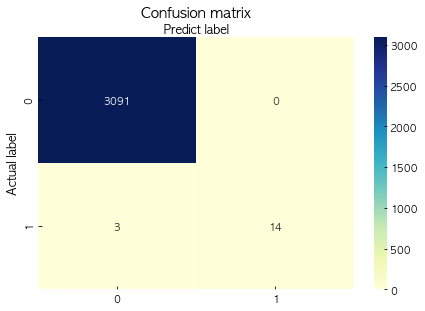

In [252]:
cnf_metrix=metrics.confusion_matrix(y_test, y_pred)
print(cnf_metrix)

class_names = ['malignant', 'benign']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
 
# 히트맵 생성
sns.heatmap(pd.DataFrame(cnf_metrix), annot=True, cmap='YlGnBu', fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predict label")
plt.show()

* 결로인데, 정상이라고 판단한 3개를 줄이는것이 관건